In [1]:
import os
import time
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import  precision_recall_fscore_support as score, classification_report, confusion_matrix, roc_curve, auc


Bad key "text.kerning_factor" on line 4 in
C:\Users\gosal\Anaconda3_2\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


### Gradient boosting

You may recall that we last encountered gradients when discussing the gradient descent algorithm in the context of fitting linear regression models.  For a particular regression model with n parameters, an n+1 dimensional space existed defined by all the parameters plus the cost/loss function to minimize.  The combination of parameters and loss function define a surface within the space.  The regression model is fitted by moving down the steepest 'downhill' gradient until we reach the lowest point of the surface, where all possible gradients are 'uphill.'  The final model is made up of the parameter estimates that define that location on the surface.

Throughout all iterations of the gradient descent algorithm for linear regression, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function never changes.  In gradient boosting, however, the underlying data do change.  

Each time we run a decision tree, we extract the residuals.  Then we run a new decision tree, using those residuals as the outcome to be predicted.  After reaching a stopping point, we add together the predicted values from all of the decision trees to create the final gradient boosted prediction.

Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters.  Most often, however, gradient boosting uses decision trees, and minimizes either the  residual (regression trees) or the negative log-likelihood (classification trees).  

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees. First, let’s fit a `DecisionTreeRegressor` to the training set.

In [2]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [3]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [4]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then we train a third regressor on the residual errors made by the second predictor:



In [5]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [6]:
X_new = np.array([[0.8]])

In [7]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [8]:
y_pred

array([0.75026781])

The figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

**<font color='teal'>Run the below cell to develop a visual representation.</font>**

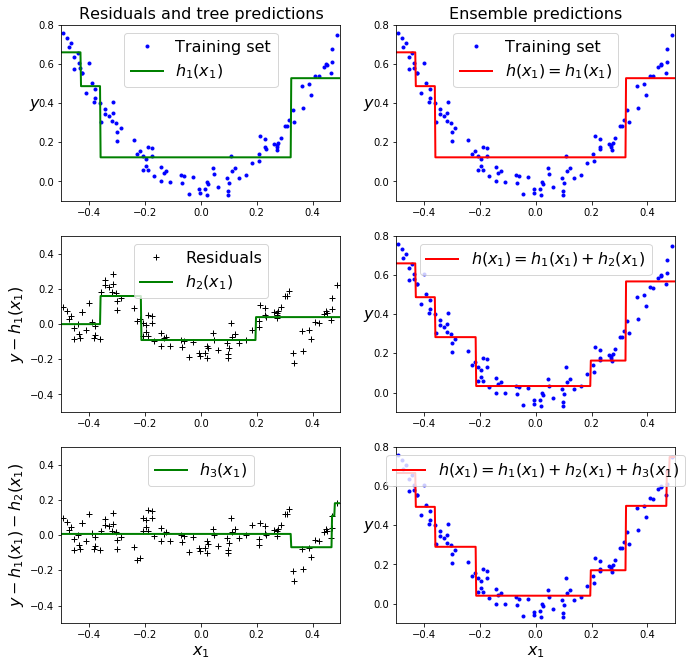

In [9]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

Now that you have solid understanding of Gradient Boosting in the regression scenario, let's apply the same algorithm to a classification problem. Specifically, the Titanic dataset and predicting survival.

**<font color='teal'>Use pandas read csv to load in the Titantic data set into a dataframe called df.</font>**

Hint: in this case you can use [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) to just throw away any incomplete rows. For the purpose of this exercise we will disregard them but obviously in the real world you need to be much more careful and decide how to handle incomplete observations. 

In [10]:
os.getcwd()

'C:\\Shalin\\Springboard bootcamp\\projects\\Gradient Boosting Case Study'

In [11]:
os.listdir()

['.ipynb_checkpoints', 'data', 'Gradient Boosting Case Study.ipynb']

In [12]:
file_name = 'C:\\Shalin\\Springboard bootcamp\\projects\\Gradient Boosting Case Study\\data\\titanic.csv'

In [13]:
df = pd.read_csv(file_name)
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


**<font color='teal'>Print the levels of the categorical data using 'select_dtypes'. </font>**

In [14]:
dfo = df.select_dtypes(include='object')

# get levels for all variables
unique_index = pd.DataFrame(df.nunique()).reset_index()
unique_index.columns = ['VarName', 'LevelsCount']
unique_index.sort_values(by='LevelsCount', ascending=False)
unique_index

,VarName,LevelsCount
0,PassengerId,891
1,Survived,2
2,Pclass,3
3,Name,891
4,Sex,2
5,Age,88
6,SibSp,7
7,Parch,7
8,Ticket,681
9,Fare,248


**<font color='teal'>Create dummy features for the categorical features and add those to the 'df' dataframe. Make sure to also remove the original categorical columns from the dataframe.</font>**

In [15]:
df = pd.DataFrame(df.drop(dfo.columns,axis =1)).merge(pd.get_dummies(dfo.drop(['Name','Cabin','Ticket'],axis =1)),left_index=True,right_index=True).drop(['PassengerId'],axis =1)
print(df.shape)
df.head()

(891, 11)


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


**<font color='teal'>Print the null values for each column in the dataframe.</font>**

In [16]:
df.isnull().sum().sort_values(ascending=False)

Age           177
Embarked_S      0
Embarked_Q      0
Embarked_C      0
Sex_male        0
Sex_female      0
Fare            0
Parch           0
SibSp           0
Pclass          0
Survived        0
dtype: int64

In [17]:
df.Age.fillna(df.Age.mean(), inplace=True)

**<font color='teal'>Create the X and y matrices from the dataframe, where y = df.Survived </font>**

In [18]:
X = df.drop('Survived', axis=1)
y = df['Survived']

**<font color='teal'>Apply the standard scaler to the X matrix.</font>**

In [19]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

**<font color='teal'>Split the X_scaled and y into 75/25 training and testing data subsets..</font>**

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state=42)

In [21]:
def train_GB(n_est, max_features, max_depth):
    gb = GradientBoostingClassifier(n_estimators = n_est, max_features = max_features, max_depth=max_depth)
    gb_model = gb.fit(X_train, y_train)
    y_pred = gb_model.predict(X_test)
    precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=1, average='binary')
    print('Est: {} / Features: {} / Depth: {} / ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        n_est, max_features, max_depth, round(precision, 3), round(recall, 3), 
        round((y_pred==y_test).sum()/len(y_pred), 3)))

In [22]:
for n_est in [20, 30, 40, 50]:
    for max_features in [2, 3, 4]:
        for max_depth in [2, 3, 4]:
            train_GB(n_est, max_features, max_depth)

Est: 20 / Features: 2 / Depth: 2 / ---- Precision: 0.795 / Recall: 0.697 / Accuracy: 0.807
Est: 20 / Features: 2 / Depth: 3 / ---- Precision: 0.805 / Recall: 0.697 / Accuracy: 0.812
Est: 20 / Features: 2 / Depth: 4 / ---- Precision: 0.827 / Recall: 0.697 / Accuracy: 0.821
Est: 20 / Features: 3 / Depth: 2 / ---- Precision: 0.788 / Recall: 0.708 / Accuracy: 0.807
Est: 20 / Features: 3 / Depth: 3 / ---- Precision: 0.827 / Recall: 0.697 / Accuracy: 0.821
Est: 20 / Features: 3 / Depth: 4 / ---- Precision: 0.813 / Recall: 0.685 / Accuracy: 0.812
Est: 20 / Features: 4 / Depth: 2 / ---- Precision: 0.788 / Recall: 0.708 / Accuracy: 0.807
Est: 20 / Features: 4 / Depth: 3 / ---- Precision: 0.811 / Recall: 0.674 / Accuracy: 0.807
Est: 20 / Features: 4 / Depth: 4 / ---- Precision: 0.824 / Recall: 0.685 / Accuracy: 0.816
Est: 30 / Features: 2 / Depth: 2 / ---- Precision: 0.833 / Recall: 0.674 / Accuracy: 0.816
Est: 30 / Features: 2 / Depth: 3 / ---- Precision: 0.818 / Recall: 0.708 / Accuracy: 0.821

Considering if the model predicted 'Survied' but the passenger didn't surve, that is very painful for the kins. That would mean the model can't affort to make false positive, hence Precision is very important for our model, so we should pick up hyperparameters with higher Precision
Also accuracy is important since we want to know that how many didnt survive for being able to accurately notify the kins
So we should choose lr, max depth and estimators in such a way that accuracy and precision is on higher side which can be achieved with n_estimators = 20

In [23]:
for max_features in [2, 3, 4]:
    for max_depth in [2, 3, 4]:
        train_GB(20, max_features, max_depth)

Est: 20 / Features: 2 / Depth: 2 / ---- Precision: 0.797 / Recall: 0.708 / Accuracy: 0.812
Est: 20 / Features: 2 / Depth: 3 / ---- Precision: 0.833 / Recall: 0.674 / Accuracy: 0.816
Est: 20 / Features: 2 / Depth: 4 / ---- Precision: 0.838 / Recall: 0.697 / Accuracy: 0.825
Est: 20 / Features: 3 / Depth: 2 / ---- Precision: 0.747 / Recall: 0.697 / Accuracy: 0.785
Est: 20 / Features: 3 / Depth: 3 / ---- Precision: 0.84 / Recall: 0.708 / Accuracy: 0.83
Est: 20 / Features: 3 / Depth: 4 / ---- Precision: 0.824 / Recall: 0.685 / Accuracy: 0.816
Est: 20 / Features: 4 / Depth: 2 / ---- Precision: 0.747 / Recall: 0.697 / Accuracy: 0.785
Est: 20 / Features: 4 / Depth: 3 / ---- Precision: 0.845 / Recall: 0.674 / Accuracy: 0.821
Est: 20 / Features: 4 / Depth: 4 / ---- Precision: 0.833 / Recall: 0.674 / Accuracy: 0.816


**<font color='teal'>Run the cell below to test multiple learning rates in your gradient boosting classifier.</font>**

- **Model 1**: Fit model 2 w/ max_features = 2, max_depth = 4

In [24]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb_1 = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 4, random_state = 0)
    start = time.time()
    gb_model_1 = gb_1.fit(X_train, y_train)
    end = time.time()
    training_time = (end - start)

    start = time.time()
    y_pred = gb_model_1.predict(X_test)
    end = time.time()
    pred_time = (end - start)
    
    print("Training time:", training_time)
    print("Test prediction time:", pred_time)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_1.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_1.score(X_test, y_test)))
    print()

Training time: 0.020987510681152344
Test prediction time: 0.0
Learning rate:  0.05
Accuracy score (training): 0.841
Accuracy score (validation): 0.821

Training time: 0.01894998550415039
Test prediction time: 0.0
Learning rate:  0.1
Accuracy score (training): 0.862
Accuracy score (validation): 0.821

Training time: 0.017960786819458008
Test prediction time: 0.0
Learning rate:  0.25
Accuracy score (training): 0.879
Accuracy score (validation): 0.812

Training time: 0.02095937728881836
Test prediction time: 0.0
Learning rate:  0.5
Accuracy score (training): 0.897
Accuracy score (validation): 0.803

Training time: 0.01795482635498047
Test prediction time: 0.0
Learning rate:  0.75
Accuracy score (training): 0.921
Accuracy score (validation): 0.798

Training time: 0.018964529037475586
Test prediction time: 0.0
Learning rate:  1
Accuracy score (training): 0.937
Accuracy score (validation): 0.767



**Model 1** : **<font color='teal'>Apply the best learning rate to the model fit and predict on the testing set. Print out the confusion matrix and the classification report to review the model performance.</font>**

- Since training time is miniscule, choose learning rate as 1 consdiering highest accuracy score to predict on test set and print out confusion matrix and classification report to review performance

In [25]:
gb_1 = GradientBoostingClassifier(n_estimators=20, learning_rate=1, max_features=2, max_depth=4, random_state=0)
gb_model_1 = gb_1.fit(X_train, y_train)

y_pred = gb_model_1.predict(X_test)
print("Accuracy score (validation) for Model 1: {0:.3f}".format(gb_1.score(X_test, y_test)))

Accuracy score (validation) for Model 1: 0.767


In [26]:
print(confusion_matrix(y_test,y_pred))

[[108  26]
 [ 26  63]]


In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       134
           1       0.71      0.71      0.71        89

    accuracy                           0.77       223
   macro avg       0.76      0.76      0.76       223
weighted avg       0.77      0.77      0.77       223



- **Model 2** : Now fit model 2 w/ max_features = 3, max_depth = 3

In [29]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb_2 = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=3, max_depth = 3, random_state = 0)
    start = time.time()
    gb_model_2 = gb_2.fit(X_train, y_train)
    end = time.time()
    training_time = (end - start)

    start = time.time()
    y_pred_2 = gb_model_2.predict(X_test)
    end = time.time()
    pred_time = (end - start)
    
    print("Training time:", training_time)
    print("Test prediction time:", pred_time)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_2.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_2.score(X_test, y_test)))
    print()

Training time: 0.020977258682250977
Test prediction time: 0.0
Learning rate:  0.05
Accuracy score (training): 0.828
Accuracy score (validation): 0.816

Training time: 0.016963958740234375
Test prediction time: 0.0
Learning rate:  0.1
Accuracy score (training): 0.844
Accuracy score (validation): 0.816

Training time: 0.014958858489990234
Test prediction time: 0.0
Learning rate:  0.25
Accuracy score (training): 0.858
Accuracy score (validation): 0.794

Training time: 0.012927055358886719
Test prediction time: 0.0
Learning rate:  0.5
Accuracy score (training): 0.880
Accuracy score (validation): 0.794

Training time: 0.013012170791625977
Test prediction time: 0.0
Learning rate:  0.75
Accuracy score (training): 0.886
Accuracy score (validation): 0.785

Training time: 0.012984752655029297
Test prediction time: 0.0
Learning rate:  1
Accuracy score (training): 0.889
Accuracy score (validation): 0.812



**Model 2** - **<font color='teal'>Apply the best learning rate to the model fit and predict on the testing set. Print out the confusion matrix and the classification report to review the model performance.</font>**

- Since training time is miniscule, choose learning rate as 1 consdiering highest accuracy score to predict on test set and print out confusion matrix and classification report to review performance

In [30]:
gb_2 = GradientBoostingClassifier(n_estimators=20, learning_rate=1, max_features=3, max_depth=3, random_state=0)
gb_model_2 = gb_2.fit(X_train, y_train)

y_pred_2 = gb_model_2.predict(X_test)
print("Accuracy score (validation) for Model 2: {0:.3f}".format(gb_2.score(X_test, y_test)))

Accuracy score (validation) for Model 2: 0.812


In [31]:
print(confusion_matrix(y_test,y_pred_2))

[[115  19]
 [ 23  66]]


In [32]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       134
           1       0.78      0.74      0.76        89

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



**<font color='teal'>Calculate the ROC for the model as well.</font>**

- ROC determination using n_estimators = 20, max_depth = 2, max_features = 4, learning_rate = 1

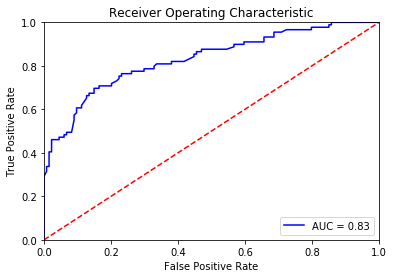

In [33]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import sklearn.metrics as metrics

y_pred_1 = gb_model_1.predict_proba(X_test)[:, 1]
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_1)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

- ROC determination using n_estimators = 20, max_depth = 3, max_features = 3, learning_rate = 1

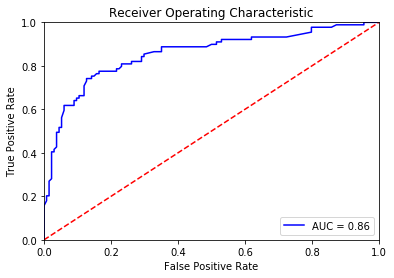

In [34]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import sklearn.metrics as metrics

y_pred_2 = gb_model_2.predict_proba(X_test)[:, 1]
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_2)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Conclusion** - AS you can see ROC is better for model 2 which had max_Depth = 3 and max_features = 3. Also as was seen that accuracy and precision scores were high for this model when plotting the classificaiton report and confusion matrix 